In [1]:
import numpy as np
import pandas as pd
import pandahouse as ph
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220320'
}

In [3]:
q12 = """
select
    exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
from {db}.feed_actions 
where
    toDate(time) >= '2022-03-15' and toDate(time) <= '2022-03-21'
    and exp_group in (1,2)
group by exp_group, user_id
"""
df12 = ph.read_clickhouse(q12, connection=connection)
df12.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [4]:
q03 = """
select
    exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
from {db}.feed_actions 
where
    toDate(time) >= '2022-03-15' and toDate(time) <= '2022-03-21'
    and exp_group in (0,3)
group by exp_group, user_id
"""
df03 = ph.read_clickhouse(q03, connection=connection)
df03.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,3,123580,13,48,0.270833
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,18,88,0.204545


#### linearized_likes

In [5]:
def get_linearized_likes(user_likes, user_views, control_ctr):
    linearized_likes = user_likes - control_ctr * user_views
    return linearized_likes

In [6]:
control_ctr_1 = df12[df12['exp_group'] == 1].likes.sum() / df12[df12['exp_group'] == 1].views.sum()
print(np.round(control_ctr_1, 4))

control_ctr_0 = df03[df03['exp_group'] == 0].likes.sum() / df03[df03['exp_group'] == 0].views.sum()
print(np.round(control_ctr_0, 4))

0.208
0.2082


In [7]:
df12['linear_likes'] = df12.apply(lambda x: get_linearized_likes(x['likes'], x['views'], control_ctr_1), axis=1)
df03['linear_likes'] = df03.apply(lambda x: get_linearized_likes(x['likes'], x['views'], control_ctr_0), axis=1)

#### t-тест и гистограммы для теста на группах 1 и 2

In [8]:
print(f'pvalue для ctr: {np.round(stats.ttest_ind(df12[df12.exp_group == 1].ctr, df12[df12.exp_group == 2].ctr, equal_var=False).pvalue, 4)}')
print(f'pvalue для линеаризованных лайков: {np.round(stats.ttest_ind(df12[df12.exp_group == 1].linear_likes, df12[df12.exp_group == 2].linear_likes, equal_var=False).pvalue, 4)}')
print('t-тест после линеаризации лайков позволяет зафиксировать разницу между группами 1 и 2')

pvalue для ctr: 0.4781
pvalue для линеаризованных лайков: 0.0
t-тест после линеаризации лайков позволяет зафиксировать разницу между группами 1 и 2


In [9]:
df12.groupby(['exp_group'])['ctr', 'linear_likes'].mean().round(4)

,ctr,linear_likes
exp_group,,
1,0.2156,-0.0000
2,0.2144,-0.6593


<AxesSubplot:xlabel='ctr', ylabel='Count'>

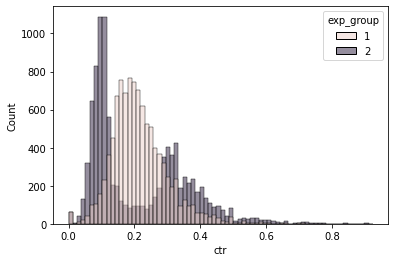

In [10]:
sns.histplot(data=df12, x='ctr', hue='exp_group')

<AxesSubplot:xlabel='linear_likes', ylabel='Count'>

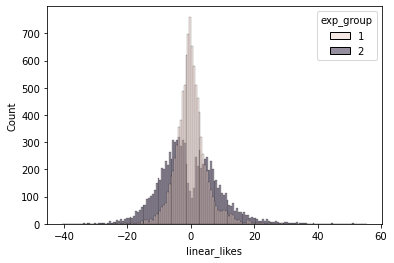

In [11]:
sns.histplot(data=df12, x='linear_likes', hue='exp_group')

#### t-тест и гистограммы для теста на группах 0 и 3

In [12]:
print(f'pvalue для ctr: {np.round(stats.ttest_ind(df03[df03.exp_group == 0].ctr, df03[df03.exp_group == 3].ctr, equal_var=False).pvalue, 4)}')
print(f'pvalue для линеаризованных лайков: {np.round(stats.ttest_ind(df03[df03.exp_group == 0].linear_likes, df03[df03.exp_group == 3].linear_likes, equal_var=False).pvalue, 4)}')
print('t-тест фиксирует разницу между группами 0 и 3 по обеим метрикам')

pvalue для ctr: 0.0
pvalue для линеаризованных лайков: 0.0
t-тест фиксирует разницу между группами 0 и 3 по обеим метрикам


In [13]:
df03.groupby(['exp_group'])['ctr', 'linear_likes'].mean().round(4)

,ctr,linear_likes
exp_group,,
0,0.2159,0.0000
3,0.2326,1.0713


<AxesSubplot:xlabel='ctr', ylabel='Count'>

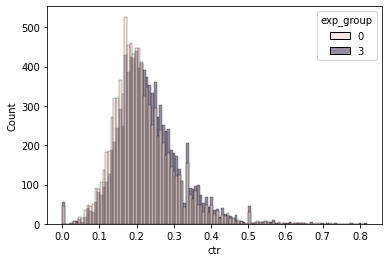

In [14]:
sns.histplot(data=df03, x='ctr', hue='exp_group')

<AxesSubplot:xlabel='linear_likes', ylabel='Count'>

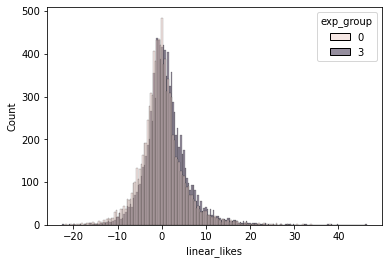

In [15]:
sns.histplot(data=df03, x='linear_likes', hue='exp_group')